c:\Users\jnicolow\AppData\Local\anaconda3\envs\genv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ikeauth.its.hawaii.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


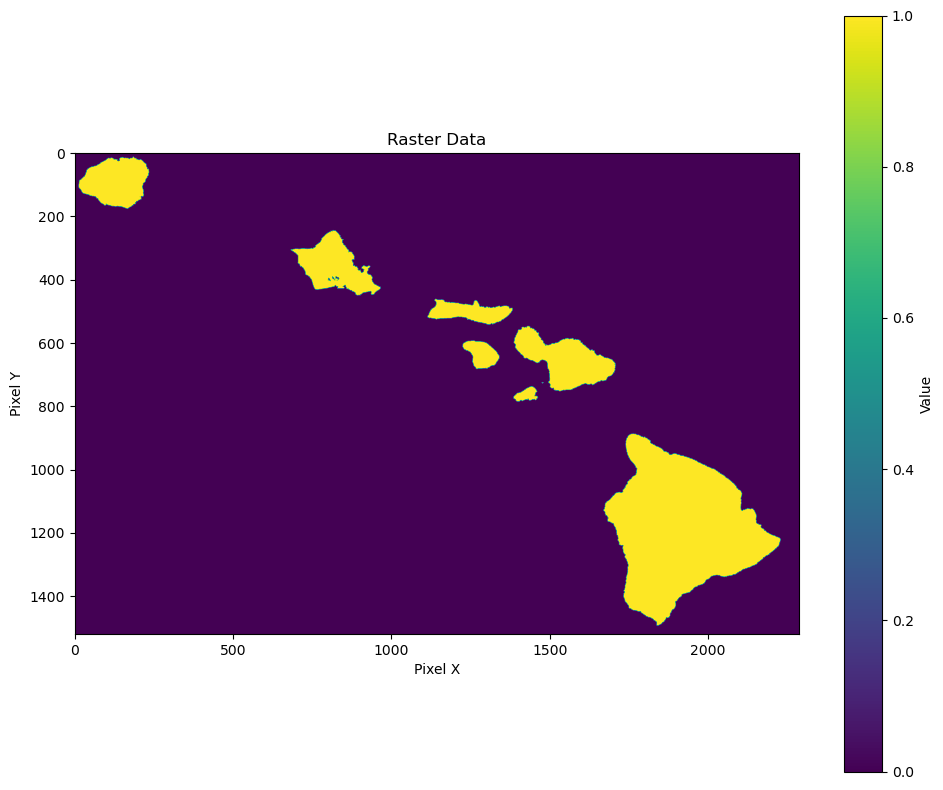

In [15]:
import os
import requests
from io import BytesIO
import rasterio
import matplotlib.pyplot as plt
import numpy as np

class FileDownloadAPI:
    """
    Find API documentation here: https://docs.google.com/document/d/1XlVR6S6aCb7WC4ntC4QaRzdw0i6B-wDahDjsN1z7ECk/edit?tab=t.0
    after base url is: <product type>/<aggregation>/<period>/<extent>[/<fill>]/<filetype>/<year>[/<month>]/rainfall_<production>_<period>_<extent>[_<fill>]_<filetype>_<year>_<month>[_<day>].<extension>
    e.g. file
    """
    def __init__(self,  
            product_type: str,  # Product type can either be 'rainfall' or 'temperature'
            year: str,           # Year as a 4-digit integer or string (e.g. 2022)
            month: str = 1,   # Month as a 2-digit string or integer (optional)
            day: str = None,     # Day as a 2-digit string or integer (optional)
            aggregation: str = "mean"  # Aggregation type ('min', 'max', or 'mean')
            
        ):
        """
        :param product_type: str, "rainfall" or "temperature"
        :param year: str or int, 4-digit year (e.g., 2022)
        :param month: str or int, 2-digit month (optional)
        :param day: str or int, 2-digit day (optional)
        :param aggregation: str, "min", "max", or "mean"
        """
        if not product_type in ['rainfall', 'temperature']: raise ValueError("product_type should be rainfall or temperature")
        self.product_type = product_type # this is rainfall or temperature

        if year >= 1990: production = 'new'
        else: production = 'legacy'
        # if not production in ['new', 'legacy']: raise ValueError("production should be new (1990-present) or legacy (1920-2012)")
        self.production = production

        if not aggregation in ["min", 'max', 'mean']: raise ValueError("aggregation should be min max or mean")
        self.aggregation = aggregation

        # if not period in ['month', 'day']: raise ValueError("period should be 'month' or 'day'")
        self.period = 'month'

        # if not extent in ['statewide', 'bi', 'ka', 'mn', 'oa']: raise ValueError("extent should be statewide, bi (big island), ka (Kauai County), mn (Maui County), or oa (Honolulu County)")
        self.extent = 'statewide' # NOTE only statewide is avaible

        # if not fill in ['raw', 'partial', None]: raise ValueError('fill should be raw (no QAQC) or partial (QAQC missing values filled)')
        # self.fill = fill
        self.fill = None # str or None, 'raw' or 'partial' (optional)
        if self.fill is None: self.fill = '' # its optional so can not include it in the url


        # if self.product_type == 'rainfall' and not filetype in ['data_map', 'se', 'anom', 'anom_se', 'metadata', 'station_data']: raise ValueError("incorrect filetype, for rainfall filetypes are: 'data_map', 'se', 'anom', 'anom_se', 'metadata', 'station_data'")
        # if self.product_type == 'temperature' and not filetype in ['data_map', 'se', 'metadata', 'station_data']: raise ValueError("incorrect filetype, for temperature filetypes are: 'data_map', 'se', 'metadata', 'station_data'")
        self.filetype = 'data_map'  # Filetype for the data ('data_map', 'se', 'anom', 'anom_se', 'metadata', 'station_data')


        extention_dict = {'data_map':'tif', 'se':'tif', 'anom':'tif', 'anom_se':'tif', 'metadata':'txt', 'station_data':'csv'}
        self.extention = extention_dict[self.filetype] # this wil be like 'csv' for example

        if product_type == 'new' and not int(year) >= 1990: raise ValueError("if production is 'new' year must be >= 1990")
        if product_type == 'legacy' and (not int(year) >= 1920 or not int(year) <= 2012) and not int: raise ValueError("if production is 'legacy' year must be 1920 to 2012")
        self.year = year

        if not month is None and int(month) > 12: raise ValueError('month must be 0 to 12')
        self.month = month
        if self.month is None: self.month = '' # its optional so can not include it in the url
        else: self.month = f"{int(self.month):02d}"

        if not day is None and int(day) > 31: raise ValueError('day must be <= 31')
        self.day = day
        if self.day is None: self.day = '' # its optional so can not include it in the url
        else: self.day = f"{int(self.day):02d}"

        self.base_url = "https://ikeauth.its.hawaii.edu/files/v2/download/public/system/ikewai-annotated-data/HCDP/production/"    
        # NOTE the format that actually work is slightly different than that fiven on the API documentation page    
        url_extension = f'{self.product_type}/{self.production}/{self.period}/{self.extent}/{self.fill}/{self.filetype}/{self.year}/{self.product_type}_{self.production}_{self.period}_{self.extent}_{self.fill}_{self.filetype}_{self.year}_{self.month}_{self.day}.{self.extention}'
        url_extension = url_extension.replace('//', '/').replace('__', '_').replace('_.', '.')

        self.url = f'{self.base_url}{url_extension}'

        self.dataset = None # NOTE this is defined with get_data



    def download_file(self, save_path):
        response = requests.get(self.url, verify=False)  # verify=False if you want to ignore SSL verification
    
        if response.status_code == 200:
            # Save the file content to the specified output filename
            with open(save_path, 'wb') as file:
                file.write(response.content)
            print(f"File downloaded successfully: {save_path}")
        else:
            print(f"Failed to download file. HTTP Status code: {response.status_code}")


    def get_data(self):
        response = requests.get(self.url, verify=False)

        if response.status_code == 200:
            file_bytes = BytesIO(response.content)
            dataset = rasterio.open(file_bytes)
            self.dataset = dataset
            return dataset
        else:
            raise Exception(f"Failed to download file. HTTP Status code: {response.status_code}")
        
    def plot_raster(self, nodata_val=-9999):
        if self.dataset is None:
            print('Call get_data to define dataset first')
        else:
            band1 = self.dataset.read(1)  # Read the first band (many GeoTIFFs are single-band)

            band1 = np.where(band1 == nodata_val, np.nan, band1)

            # Optional: Normalize values for better contrast
            min_val = np.nanmin(band1)
            max_val = np.nanmax(band1)
            scaled = (band1 - min_val) / (max_val - min_val)
            
            plt.figure(figsize=(10, 8))
            plt.imshow(scaled, cmap='viridis')  # You can use other colormaps too
            plt.colorbar(label='Value')
            plt.title("Raster Data")
            plt.xlabel("Pixel X")
            plt.ylabel("Pixel Y")
            plt.tight_layout()
            plt.show()

            



test = FileDownloadAPI('rainfall', year =2025, month=1)
# test.download_file(save_path = 'test.tif')
dataset = test.get_data()
test.plot_raster()


In [10]:
import numpy as np
np.unique(dataset.read(1))

array([-3.4000000e+38,  2.0339863e+01,  2.0370369e+01, ...,
        9.6138696e+02,  9.6307141e+02,  9.9695148e+02], dtype=float32)

In [2]:
import requests

def download_rainfall_data(production, period, extent, fill, filetype, year, month, day=None, output_filename='rainfall_data'):
    base_url = "https://ikeauth.its.hawaii.edu/files/v2/download/public/system/ikewai-annotated-data/HCDP/production/rainfall"
    
    # Construct the URL
    url = f"{base_url}/{production}/{period}/{extent}/{fill}/{filetype}/{year}/{month}/rainfall_{production}_{period}_{extent}_{fill}_{filetype}_{year}_{month}"
    
    if day:
        url += f"_{day}"
    
    url += f".{filetype}"
    
    # Send the GET request (no authentication required)
    response = requests.get(url, verify=False)  # verify=False if you want to ignore SSL verification
    
    if response.status_code == 200:
        # Save the content to a file
        with open(output_filename, 'wb') as f:
            f.write(response.content)
        print(f"Data downloaded successfully: {output_filename}")
    else:
        print(f"Failed to download data. HTTP Status code: {response.status_code}")

# Example usage
download_rainfall_data(
    production="new",
    period="month",
    extent="statewide",
    fill="partial",
    filetype="tif",
    year="2012",
    month="03",
    day=None,  # Optional
    output_filename="rainfall_data_2012_03.tif"
)


c:\Users\jnicolow\AppData\Local\anaconda3\envs\genv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ikeauth.its.hawaii.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Failed to download data. HTTP Status code: 404


In [3]:
import requests

def download_rainfall_file(url, output_filename):
    # Send the GET request to download the file
    response = requests.get(url, verify=False)  # verify=False if you want to ignore SSL verification
    
    if response.status_code == 200:
        # Save the file content to the specified output filename
        with open(output_filename, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully: {output_filename}")
    else:
        print(f"Failed to download file. HTTP Status code: {response.status_code}")

# Example: Construct the URL and download the file
url = "https://ikeauth.its.hawaii.edu/files/v2/download/public/system/ikewai-annotated-data/HCDP/production/rainfall/new/month/statewide/data_map/2012/rainfall_new_month_statewide_data_map_2012_03.tif"
output_filename = "rf_test.tif"

download_rainfall_file(url, output_filename)


c:\Users\jnicolow\AppData\Local\anaconda3\envs\genv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ikeauth.its.hawaii.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File downloaded successfully: rf_test.tif
